# **Using a Genetic Algorithm to Guess a Phrase**

In this notebook, a genetic algorithm will be implemented to guess a specified phrase.

For a phrase of length $L$ constructed from $N_C$ possible characters, the number of permutations of possible phrases is given by $(N_C)^L$. If $N_P$ (population size) guesses are made each generation then on average, it will take $\frac{(N_C)^L}{N_P}$ generations to correctly guess the phrase. This number grows large quickly, and so this genetic algorithm aims to implement a more efficient algorithm to find a solution.

# Importing relevant libraries.

The datetime library will be used to time how long the algorithm takes to find a solution. NumPy will be used to create arrays to efficiently analyse the different population members, as well as to generate random numbers. Matplotlib will be used to plot the results.

In [38]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("bmh")

# Creating the classes.

The following class is used to represent an individual which has genetic information. In this case, the genes are different characters, and a sequence of these genes is a chromosome which can be mixed between individuals each generation. The individuals with better chromosomes (i.e. a higher fitness score) are more likely to reproduce and pass on their genes to future generations.

Their fitnesses are calculated by checking the number of characters in their chromosome which match a specified phrase and then squaring that number.

To crossover two chromosomes to construct a new sequence, genes are taken randomly from the two with equal probability, and there is also a chance for the gene to mutate and choose a random character.

In [39]:
class population_member:
  """
  This class creates a member of a population which has a chromosome of a
  specified length. The genes in the chromosome are chosen from the provided
  possible genes. The members can mix their chromosomes via crossover and
  there is a random chance for the genes to mutate during this process,
  controlled by the mutation rate.
  """
  def __init__(self, length, genes, mutation_rate=10):
    """
    Initialise a member for the population.

    Inputs:
      length: int, length of chromosome
      genes: list, all the possible genes
      mutation_rate: int, probability for a gene to randomly mutate
    """
    self.chromosome = ""
    self.new_chromosome = ""
    self.length = length
    self.genes = genes

    self.mutation_rate = mutation_rate
    self.fitness = 0

    self.generate_chromosome()

  def __str__(self):
    """
    Return the member's chromosome.
    """
    return self.chromosome

  def random_char(self):
    """
    Return a random gene from the possible genes.
    """
    return self.genes[np.random.randint(0, len(self.genes))]

  def generate_chromosome(self):
    """
    Generate a random sequence of genes for the chromosome.
    """
    self.chromosome = ""

    for _ in range(self.length):
      self.chromosome += self.random_char()
  
  def calculate_fitness(self, phrase):
    """
    Calculate the member's fitness based on the provided phrase.

    Inputs:
      phrase: str, used to compare chromosome to phrase and calculate fitness
    """
    self.fitness = 0
    score = 0

    for i in range(self.length):
      if self.chromosome[i] == phrase[i]:
        score += 1
    
    self.fitness = score ** 2
    return self.fitness

  def crossover(self, parentA, parentB):
    """
    Crossover the chromosomes of two parents to create a new chromosome.

    Inputs:
      parentA: population_member, used to construct new chromosome
      parentB: population_member, used to construct new chromosome
    """
    new_chromosome = ""

    for i in range(self.length):
      prob = np.random.randint(0, 100)

      # Half of the genes will come from parentA
      if prob < (100 - self.mutation_rate) / 2:
        new_char = parentA.chromosome[i]
      # Half of the genes will come from parentB
      elif prob < (100 - self.mutation_rate):
        new_char = parentB.chromosome[i]
      # Chance for a random genes to be selected
      else:
        new_char = self.random_char()

      new_chromosome += new_char

    self.new_chromosome = new_chromosome

  def apply_new_chromosome(self):
    """
    Overwrite the member's chromosome with the new chromosome from crossover.
    """
    self.chromosome = self.new_chromosome

The following class is used to generate a population of the members belonging to the above class. It is also used to run the algorithm.

Each generation, the fitnesses of each member is evaluated. These fitnesses are stored in an array which is used to determine which individual has the highest fitness, as well as to calculate the average fitness for that generation. The highest fitness is used to normalise the fitnesses to be in the range [0, 1]. 

The normalised fitnesses are used to select parents for the next generation of individuals via the Rejection Sampling technique. A parent is chosen at random along with a random float between 0 and 1. If this number is less than than the normalised fitness of the parent, and it is accepted. This is a memory efficient way of making members with higher fitnesses more likely to reproduce.

For each individual of the new generation, two different parents are selected this way. Their chromosomes are mixed to generate a new sequence for that individual.

The program terminates when a member of the population has a chromosome which completely matches the specified phrase. The population fitnesses can then be plotted and analysed.

In [40]:
class population:
  """
  This class creates a population of members that will be trying to guess a
  provided phrase. The number of members in this population is determined by the
  population size. The members can select genes from the provided genes,
  and these genes in their chromosomes randomly mutate according to a
  specified mutation rate.
  """
  def __init__(self, population_size, phrase, mem_genes, mutation_rate=10):
    """
    Initialise a population of members of a specified size. The population uses
    a phrase for the members to calculate their fitness.

    Inputs:
      population_size: int, number of members for the population
      phrase: str, the phrase to be guessed by the members
      mem_genes: list, possible genes to be used by the members' chromosomes
      mutation_rate: int, probability for members' chromosomes to mutate
    """
    self.population = np.array([population_member(len(phrase), mem_genes, mutation_rate) for _ in range(population_size)])
    self.population_size = population_size
    self.phrase = phrase
    self.mem_genes = mem_genes

    self.best_chromosome = ""
    self.max_fitness = 0
    self.population_fitness = np.empty(population_size)
    self.generation = 0

    self.max_fitness_history = []
    self.avg_fitness_history = []

  def __str__(self):
    """
    Return population size, phrase, and the possible genes.
    """
    return ("Population Size: %s\nPopulation Phrase: %s\nMember Genes: %s" % (self.population_size, self.phrase, self.mem_genes))

  def print_members(self):
    """
    Prints the chromosomes of each member in the population.
    """
    for index in range(self.population_size):
      print("Member %s Chromosome: %s" % (index + 1, self.population[index]))

  def print_avg_gens(self):
    """
    Prints the average number of generations required to guess the phrase if
    all guesses were random.
    """
    num_gens = (len(self.mem_genes) ** len(self.phrase)) / self.population_size
    print("If all guesses are random, it would take on average %s generations to guess the phrase." % num_gens)

  def calculate_population_fitness(self):
    """
    Calculates the fitnesses of each member in the population.
    """
    return np.array([member.calculate_fitness(self.phrase) for member in self.population])

  def evaluate(self):
    """
    Calculate the fitnesses of each member in the population and add the max
    and average fitness to lists.
    """
    # Calculate population fitness
    self.population_fitness = self.calculate_population_fitness()
    sorted = self.population[np.argsort(self.population_fitness)]

    # Find the member with the highest fitness
    best = sorted[-1]
    self.best_chromosome = best.chromosome
    self.max_fitness = best.fitness

    # Add fitness data to lists
    self.max_fitness_history.append(self.max_fitness)
    self.avg_fitness_history.append(np.average(self.population_fitness))

  def select_parent(self, parent):
    """
    Uses the Rejection Sampling technique to choose whether or not to use the
    provided parent for crossover.

    Inputs:
      parent: population_member, potential parent to use for crossover
    """
    if (np.random.uniform(0, 1) < parent.fitness / self.max_fitness):
      return parent
    return None

  def evolve(self):
    """
    Crossover the chromosomes of the members and overwrite their existing
    chromosomes.
    """
    # Select parents for crossover
    for member in self.population:
      parentA = None
      parentB = None

      while parentA is None:
        potential_parent = self.population[np.random.randint(self.population_size)]
        if potential_parent != member:
          parentA = self.select_parent(potential_parent)

      while parentB is None:
        potential_parent = self.population[np.random.randint(self.population_size)]
        if potential_parent != parentA and potential_parent != member:
          parentB = self.select_parent(potential_parent)

      member.crossover(parentA, parentB)

    # Overwrite the chromosome with the new chromosome
    for member in self.population:
      member.apply_new_chromosome()

    # Increase generation
    self.generation += 1

  def run(self):
    """
    Run the evolution process.
    """
    self.generation = 1

    while True:
      # Evaluate the population
      gen = "Generation %s \t||" % self.generation
      self.evaluate()

      # Correct phrase found so break out of the loop
      if self.best_chromosome == self.phrase:
        print("%s Phrase solved to be: %s" % (gen, self.best_chromosome))
        break

      # Return the closest match and its associated fitness then evolve.
      print("%s Best Chromosome: %s \t|| Max Fitness: %s" % (gen, self.best_chromosome, self.max_fitness))
      self.evolve()

  def analyse(self):
    """
    Plot the max and average fitnesses for each generation.
    """
    plt.figure(figsize=(14, 8))
    
    x = np.arange(self.generation)
    normalisation = np.max(self.max_fitness_history)

    plt.plot(x, self.max_fitness_history / normalisation, label='Max Fitness', c='g')
    plt.plot(x, self.avg_fitness_history / normalisation, label='Avg Fitness')
    plt.title("Population Fitness vs Generation No.", fontsize=16)
    plt.xlabel("Generation no.", fontsize=16)
    plt.xlim([x[0], x[-1]])
    plt.xticks(fontsize=16)
    plt.ylabel("Fitness", fontsize=16)
    plt.ylim([0, 1])
    plt.yticks(fontsize=16)
    plt.legend(loc='best', fontsize=16)
    plt.show()

# Configuring the program. 

The possible genes an individual's chromosome can contain are provided as a list. The population size and mutation rate is then defined. A phrase is also chosen for the population members to guess.

In [41]:
genes = list("0123456789 abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,!?") # Genes to be used by the members

phrase = "I am a genetic algorithm!" # Phrase to be guessed by the members
mutation_rate = 3 # Percentage of genes in chromosomes to mutate
population_size = 200 # Number of members in the population

# Running the algorithm.

A summary of the population is shown as well as the average number of generations required by the population to correctly guess the phrase if all phrases were completely random and did not learn from previous generations.

In [42]:
mypop = population(population_size, phrase, genes, mutation_rate)
print(mypop)
mypop.print_avg_gens()

Population Size: 200
Population Phrase: I am a genetic algorithm!
Member Genes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '.', ',', '!', '?']
If all guesses are random, it would take on average 2.243055770519904e+43 generations to guess the phrase.


In [43]:
begin_time = datetime.datetime.now()

mypop.run()

dt = datetime.datetime.now() - begin_time
dt_m = int(dt.total_seconds() // 60)
dt_s = int(dt.total_seconds() - (dt_m*60))
print("\n\nDone! The time it took is %sm %ss." % (dt_m, dt_s))

Generation 1 	|| Best Chromosome: JmYZddi5WnU?jckafku2oYv n 	|| Max Fitness: 9
Generation 2 	|| Best Chromosome: kCY4 l,5Jnr?jc!afku29YsM! 	|| Max Fitness: 25
Generation 3 	|| Best Chromosome: bmwYUdi8cn7,6c aM8uI2KvP! 	|| Max Fitness: 25
Generation 4 	|| Best Chromosome: IDi2 e wStibid a2KohoYU 2 	|| Max Fitness: 49
Generation 5 	|| Best Chromosome: mDoB ViHGtMtic a2gohoYPkr 	|| Max Fitness: 64
Generation 6 	|| Best Chromosome: Izi2 a gWtiUic aXZohTYw 2 	|| Max Fitness: 100
Generation 7 	|| Best Chromosome: 82o1 V HGn1h!ckargorothL! 	|| Max Fitness: 121
Generation 8 	|| Best Chromosome: J,oYda grjatXc aMgcrEthm! 	|| Max Fitness: 169
Generation 9 	|| Best Chromosome: sUxm ao2S?73ic a2gorAthYr 	|| Max Fitness: 144
Generation 10 	|| Best Chromosome: Imim akHSn1tmc argorbYhm! 	|| Max Fitness: 225
Generation 11 	|| Best Chromosome: IUam 6 5Wn2tQc argdr2thm! 	|| Max Fitness: 256
Generation 12 	|| Best Chromosome: IkimhaQ5WnUtic aVgorEthu! 	|| Max Fitness: 225
Generation 13 	|| Best Chromoso

# Analysing the results.

The following graph shows the maximum and average fitness of the population each generation. It can be seen that initially, the fitness increases rapidly as the population is predominantly comprised of random guesses. The population then begins to converge on the correct phrase slowly, and the differences in the guesses are determined mostly due to random mutations.

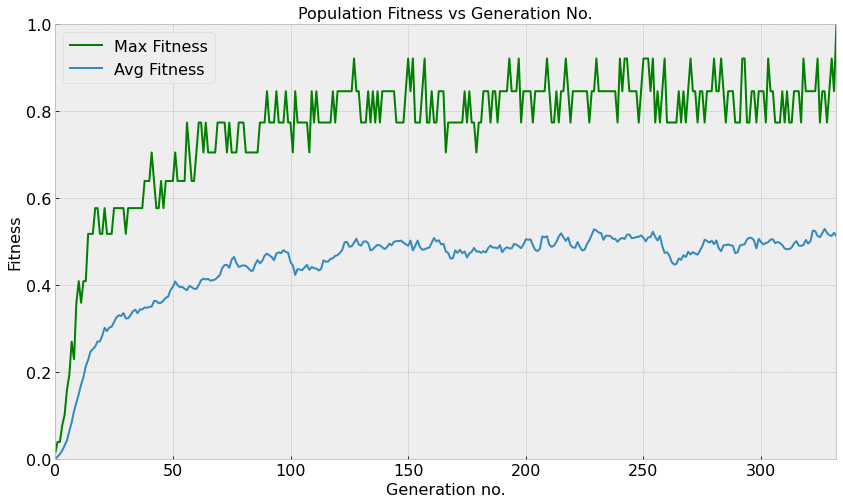

In [44]:
mypop.analyse()